# Timeseries with recurrent neural networks

In [58]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import csv
import kerastuner as kt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda, GRU, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from utils import *
tf.keras.backend.set_floatx('float64')

2.3.1


# Loading data, transforming with a windowed dataset generator
## the windowed datagenerator

Just like we have seen with the images, it is usefull to have a generator.
Our generator will do a few things:
- it helps with managing memory
- we can squeeze more juice out of our data
- we control data manipulation at a seperate place. This means we can leave the data itself intact, and manipulate it in a controlled way just before feeding it to the model, without messing with the data on disk.

Because we will multiply the amount of data we have by manipulating it, it is much more memory efficient to do the manipulation just in time, as opposed to doing all the manipulations, and keeping that in memory.

I will first show you the complete generator, and then walk through every line, explaining what it does.

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, horizon=1):
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True) # shifted windows. +1 for target value
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon)) # map into lists of size batch+target
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:])) # split into data and target, x and y
    return ds.batch(batch_size).prefetch(1)

To show how this works, let's start with a dummy dataset. We will take just the numbers ranging for 0 to 9.

In [20]:
test = [*range(10)]
testserie = tf.data.Dataset.from_tensor_slices(test)

for x in testserie:
    print(x)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


With `data.Dataset.from_tensor_slice` we create a `TensorSliceDataset`.
If we iterate through it, we can see that we have 10 `Tensor`s, each containing of just a single `int32` digit.

For a timeseries, we can create a windowed dataset from a series. This means we slide a window over the data, never leaking data from the future into the past.

In [21]:
window_size = 5
horizon = 1
testserie = testserie.window(window_size + horizon, shift=1, drop_remainder=True) 

for window in testserie:
  print(list(window.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[2, 3, 4, 5, 6, 7]
[3, 4, 5, 6, 7, 8]
[4, 5, 6, 7, 8, 9]


The window-size is the "window" we "slide" over the timeseries. It will be the small chunck of data we will feed into the model to predict the future. 

By setting `window_size` to 5, we will feed the model 5 time steps from the past (our `X`). Because we will also need a certain amount of timesteps into the future to predict, we will add `+1` to our `window_size`. Later on, we will split this off to create a `y`.

With `shift=1`, we let the timeseries skip one step into the future every time.
As you can see, we end up with five timeseries that we can feed into our model!

The `.window` function makes the shape of our data nested. To fix that, we usually use a `flat_map` to flatten the data again. By batching the data in exactly the size of our window (which was `window_size+1`), we will get a flat version of the windowed timeseries

In [22]:
testserie = testserie.flat_map(lambda w: w.batch(window_size + horizon))
for window in testserie:
  print(window)

tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int32)
tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
tf.Tensor([3 4 5 6 7 8], shape=(6,), dtype=int32)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int32)


This is the same like before (we have 5 timeseries), it's just in a shape we can access easier.

Now, let's shuffle them in batches of 2. This means we take a batch of two timeseries, shuffle them, and take the next batch, shuffle them, etc. 

In [23]:
shuffle_buffer = 2
testserie = testserie.shuffle(shuffle_buffer)
for window in testserie:
  print(window)

tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int32)
tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int32)
tf.Tensor([3 4 5 6 7 8], shape=(6,), dtype=int32)


But, untill now, we had a window of length `window+1`, being our `X` and `y` together. 

We need to split them into a past that is the `X` data, and a horizon `y` into the future that should be predicted, based on the past.

In [24]:
testserie = testserie.map(lambda w: (w[:-horizon], w[-horizon:]))

for x,y in testserie:
  print('x: ', x)
  print('y: ', y)

x:  tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)
y:  tf.Tensor([6], shape=(1,), dtype=int32)
x:  tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int32)
y:  tf.Tensor([7], shape=(1,), dtype=int32)
x:  tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int32)
y:  tf.Tensor([8], shape=(1,), dtype=int32)
x:  tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
y:  tf.Tensor([5], shape=(1,), dtype=int32)
x:  tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int32)
y:  tf.Tensor([9], shape=(1,), dtype=int32)


This is our final data! We have a past, `X`, and a future, `y`.

And finally, we put this into batches. Every time the generator is asked for a new set of data, it will spit out an (x,y) tuple of batch_size. We also use prefetch: this parallelizes the loading of a new batch to speed up things.

In [25]:
batch_size = 2
testserie = testserie.batch(batch_size).prefetch(1)

In [26]:
for x, y in testserie:
    print(x)
    print(y)
    break

tf.Tensor(
[[0 1 2 3 4]
 [2 3 4 5 6]], shape=(2, 5), dtype=int32)
tf.Tensor(
[[5]
 [7]], shape=(2, 1), dtype=int32)


# Conv1D layer

In the lesson about the images, we have already encountered the idea of convolutions: a way the let the model generate features, all by itself. We did this by sliding a 'filter' over the 2D data structure, summarizing what the filter could see.

We can apply exactly the same mechanism, but this time on 1D data.
To see how the Conv1D layer works, let's have a look at a timeserie and apply different filters and kernels.

First, a note on the dimensionality. We have encountered different layers, each requiring a different dimensionality. Uptill now, we have seen as main computational layers:
- `Dense` : expecting `(batch x features)`
- `Conv2D` : expecting `(batch x width x height x channels)`

To that, we will add a `Conv1D` layer. Because we don't have `width x height` in a 1D case, we will shrink those two dimensions into 1D. In the case of timeseries, this dimension will be the amount of timesteps we make. That gives us:
- `Conv1D` : expecting `(batch x timesteps x channels)`

In this case, channels don't mean colors (like in the RGB images) but the will be features of the timeseries.

Let's say we want to predict the weather. We take the past 10 days (so, `window=10`). And we want to predict 1 day into the future (so, `horizon=1`). But how many features do we use? Let's say we use `temperature`, `mm rain` and `hours of sunshine`. That would give us 3 channels. So, with a batch size of 32, we will get a data shape: `(32, 10, 3)`.

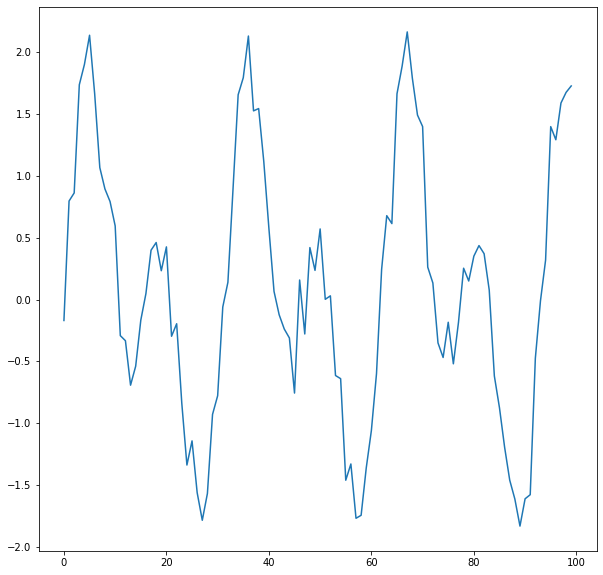

In [27]:
# first, generate a 100 timesteps
t = np.linspace(0, 20, 100)

# we generate a signal, and add some noise
y = np.sin(t) + np.sin(2*t) + np.random.normal(scale=0.2, size=100)

# we get the data in the shape for timeseries: (batch x timesteps x channels)
# in this case, we have just one batch and one channel
y = y[np.newaxis, :, np.newaxis]
plt.figure(figsize=(10,10))
plt.plot(y[0])

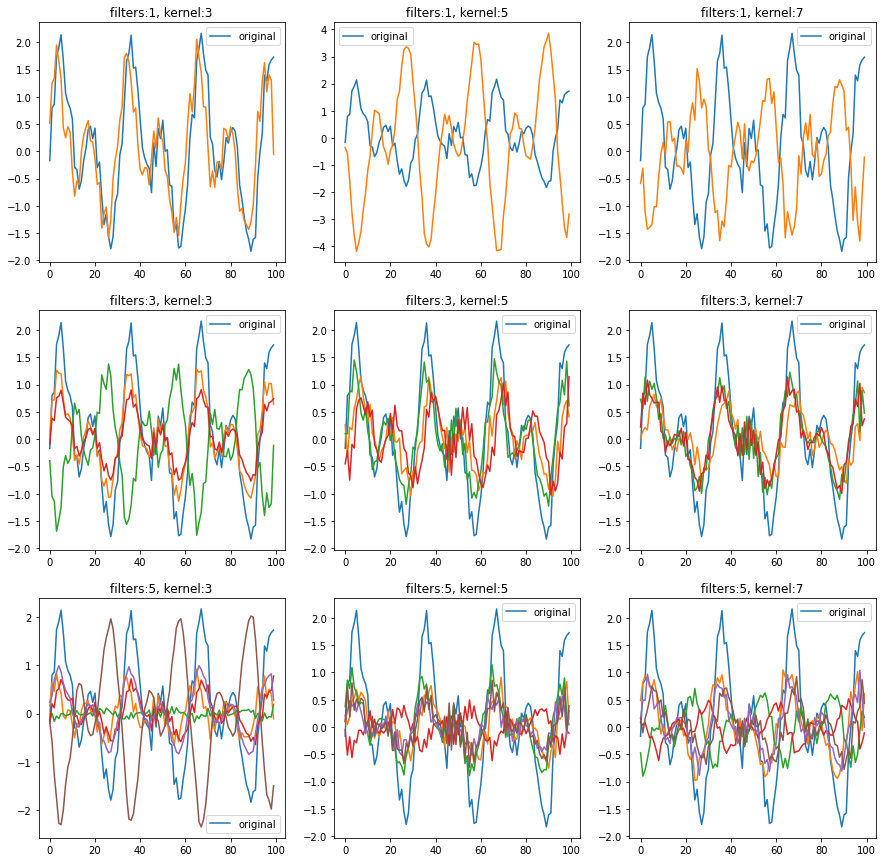

In [31]:
tf.random.set_seed(2)
plt.figure(figsize=(15,15))

for i in range(3):
    # we will test different amounts of filters
    filters = i*2+1
    for j in range(3):
        # prepare the place in the subplot
        place = (i*3)+(j+1)
        ax = plt.subplot(3, 3, place)
        
        # test different sizes of kernels
        kernels = j*2+3
        
        # now, apply the 1D Convolution
        convs = tf.keras.layers.Conv1D(filters, kernels, padding = 'same')(y)
        
        # and plot it.
        plt.plot(y[0], label = 'original')
        plt.title('filters:{0}, kernel:{1}'.format(filters, kernels))
        plt.plot(convs[0]);
        plt.legend()

So, what are features in this case? Some filters might specialize in removing noise (smoothing the signal, eg filter1/kernel5/orange or filter5/kernel3/brown). Others might specialize in increasing the peaks, while flattening out the low intensity signals. Other filters might invert the signal (eg filters3/kernel3/green) etc. etc.

By increasing the amount of filters, we will get more features. 
By increasing the kernelsize, we will get a larger chunck of data that is taken into account to generate a feature.

# Loading actual data

In [32]:
data = pd.read_csv('~/shared/Sunspots.csv')
data

,id,Date,MonthlyMean
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9


This is data on sunspots, since 1749.

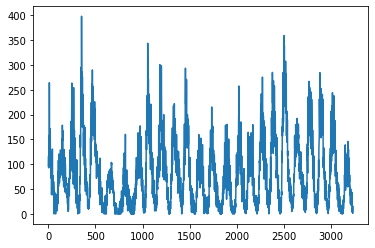

In [33]:
series = data['MonthlyMean']
plt.plot(series)

So let's make a train-test split. Note that we split on past-future.

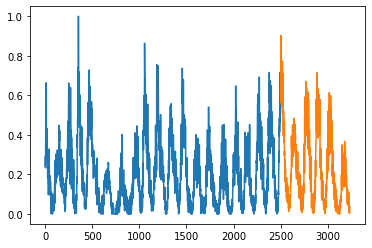

In [38]:
# Train test split
split = 2500
train = series[:split]

norm = max(train)
test = series[split:]


train = train / norm
test = test/ norm
plt.plot(train)
plt.plot(test)

In [39]:
# we need the shape to be: (timesteps x features)
# we have just one feature, so (timesteps x 1)
train = np.array(train)[:, np.newaxis]
test = np.array(test)[:, np.newaxis]
train.shape

(2500, 1)

Now, let's use our windowed datagenerator.

Regarding the windowsize, we will have to ask ourselves: what is a reasonable time, we will need to look into the past to be able to predict the future? If we make it too long, we will get irrelevant data (eg, does the amount of sunspots a hundred years still impact significantly the sunspots in 2020? If you think so, you should increase your window by a lot!)

In [141]:
window_size = 32 
batch_size = 32
shuffle_buffer = 25
horizon = 1
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)

valid_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [142]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    seq_size = x.shape[1]
    break

(32, 32, 1)
(32, 1, 1)


Checking the shape, we see that it is correct:
For the `X`, we have a batch size of 32, and 32 timesteps in the past, with one channel.
For the `y`, we also have a32 batch size, but just 1 timestep for 1 channel.

# Exploring baseline models

In [143]:
def generate_prediction(model, series, window, horizon, figsize=(10,10)):
    ''' After a model is trained, we can check the predictions.
    This function generates predictions, given a model and a timeseries, for a given window in the past
    and a horizon in the future. 
    It returns both the prediction and a plot.'''

    # make sure we have an np.array
    series = np.array(series)
    # calculate the amount of horizons we can predict in a given series
    batches = int(np.floor(len(series) / horizon))
    
    # we migth end up with some rest, where we don't have enough data for the
    # last prediction, so we stop just before that
    end = batches * horizon - window
    yhat = []
    
    # for every batch
    for i in range(batches):
        # skip the horizons we already predicted
        shift = i * horizon
        
        # take the window from the past we need for predicting, skipping what we already predicted
        X = series[0+shift:window+shift]
        
        # add a dimension, needed for the timeseries
        X = X[np.newaxis, :]
        
        # predict the future horizon, given the past window
        y = model.predict(X).flatten()[:horizon]
        # collect as a list of predictions
        yhat.append(y)
    
    # transform the appended results into a single numpy array
    yhat = np.concatenate(yhat, axis=None)[:end]

    plt.figure(figsize=figsize)
    plt.plot(yhat, label = 'prediction')
    plt.plot(series[window:], label = 'actual')
    plt.legend()
    
    return yhat

In [144]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

## Linear model
We start with a linear baselinemodel, of just a single `Dense` layer with one unit. This is equal to a linear model.

In [145]:
%%time
result = {}
from tensorflow.keras.layers import Flatten
model = Sequential([
    Flatten(input_shape = [32,1]),
    Dense(horizon)
])
model.compile(loss="mse", optimizer=Adam())
model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 33        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 24.6 ms


In [146]:
%%time
result['base'] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop], verbose=1)

Epoch 1/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0302 - val_loss: 0.0233
Epoch 2/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0186 - val_loss: 0.0155
Epoch 3/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 0.0122
Epoch 4/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 5/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 6/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 7/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 8/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 9/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 10/100
78/78 [==============================] - 1s 9ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 

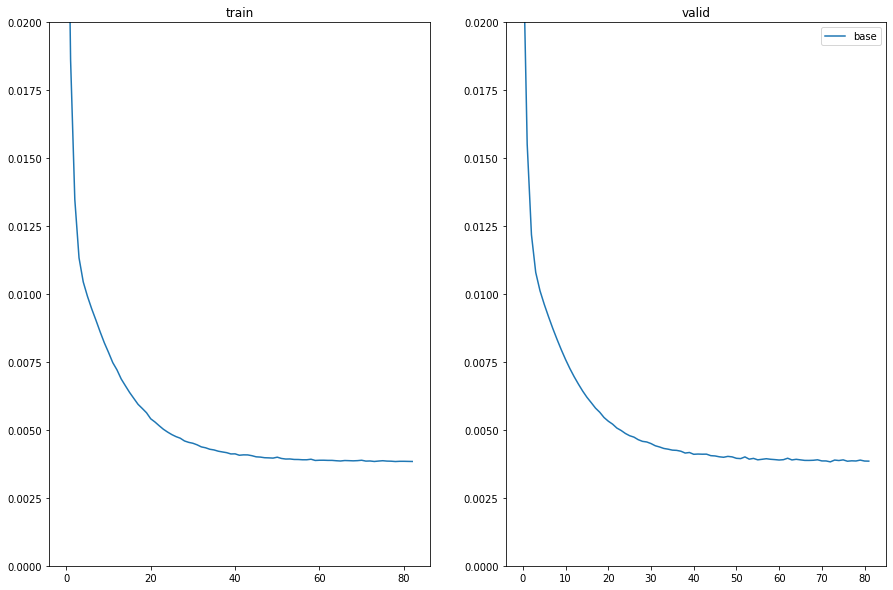

In [147]:
plot_results(result, ymin= 0, ymax=0.02)

# Simple RNN, 1 unit
And a simpleRNN. As `input_shape`, we leave out the batch_size as we always do. So we need to specify `(timesteps x channels)`. In this case, we can choose not to specify the length of the timesteps by setting it to `None`. The model will pick that up by itself. We will set the channels to one.

In [152]:
%%time
model = Sequential([
    SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer=Adam())
result['simpleRNN'] = model.fit(train_set,epochs=100, validation_data=valid_set, verbose=1)

Epoch 1/100
78/78 [==============================] - 1s 14ms/step - loss: 0.0367 - mape: 1073577.4617 - val_loss: 0.0274 - val_mape: 991645.7450
Epoch 2/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0229 - mape: 1235809.3898 - val_loss: 0.0196 - val_mape: 1673076.8548
Epoch 3/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0176 - mape: 1926546.4296 - val_loss: 0.0160 - val_mape: 2274120.8842
Epoch 4/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0150 - mape: 2475752.1308 - val_loss: 0.0144 - val_mape: 2685450.1402
Epoch 5/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0139 - mape: 2828044.2286 - val_loss: 0.0135 - val_mape: 2930698.9639
Epoch 6/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0133 - mape: 3011469.4802 - val_loss: 0.0131 - val_mape: 3045050.8258
Epoch 7/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0129 - mape: 3110302.9053 - val_loss: 0.0127 - va

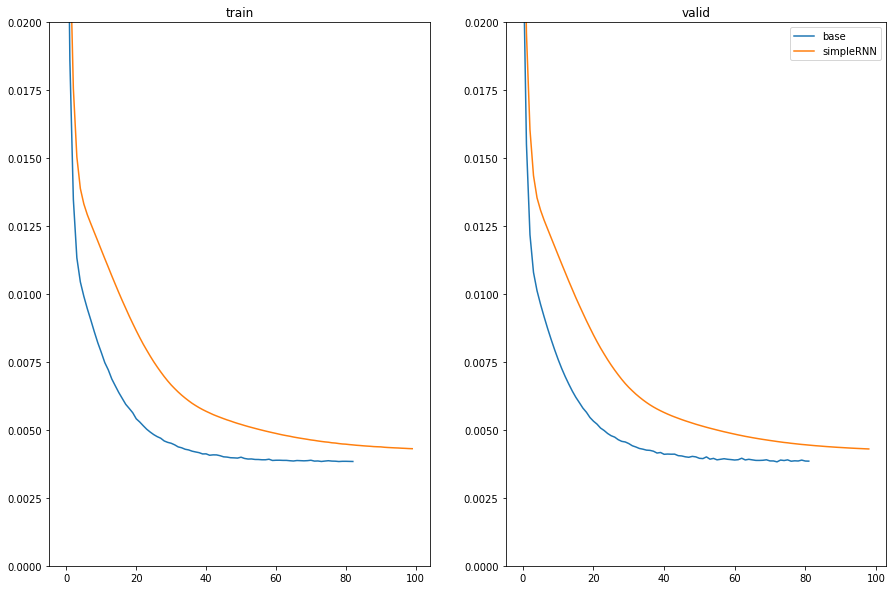

In [156]:
plot_results(result, ymax=0.02)

Ok, so far, the RNN isn't really impressive. With just one unit, it is outperformed by the Dense layer with one unit, which is essentially a simple linear model! Let's see the actual prediction of the RNN.

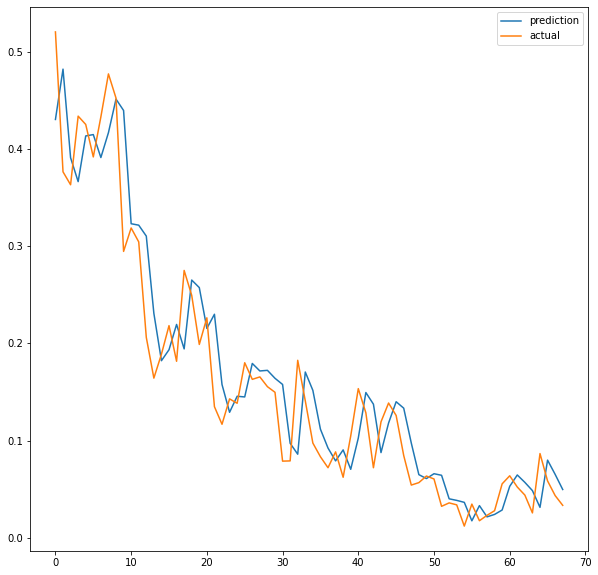

In [155]:
pred = generate_prediction(model, test[:100], window = 32, horizon = horizon)

It seems like it is making a naive prediction (just taking the past as a prediction. If it rained yesterday, my prediction is that it will rain tomorrow).

In addition to that, it is a slow learner. Maybe we should increase the learning rate.

In [157]:
%%time
model = Sequential([
    SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer=Adam(lr=1e-2))
result['simpleRNN_highlr'] = model.fit(train_set,epochs=100, validation_data=valid_set, verbose=1)

Epoch 1/100
78/78 [==============================] - 1s 13ms/step - loss: 0.2552 - val_loss: 0.0832
Epoch 2/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0608 - val_loss: 0.0425
Epoch 3/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0347 - val_loss: 0.0264
Epoch 4/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0221 - val_loss: 0.0170
Epoch 5/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0143 - val_loss: 0.0110
Epoch 6/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 7/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 8/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 9/100
78/78 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 10/100
78/78 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0042

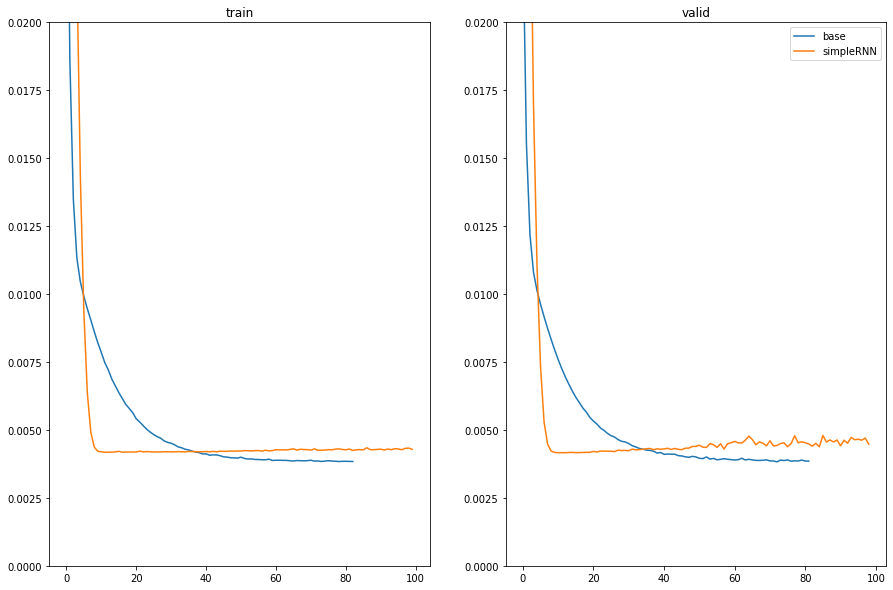

In [158]:
plot_results(result, ymax=0.02)

## Deep RNN, learning rate schedule
If you see a learning rate flatten out like that, you might want to consider dropping the learning rate after some initial epochs. Initially, it drops very steep. That is good. But then, it really flattens out, meaning it just stopped learning. That could mean two things:

- the signal is just noisy, and there is no pattern left to discover. We can't learn noise, so we can't improve above a certain threshold.
- While the high learning rate helps to drop fast, it is to high to finetune the model. It keeps 'overshooting' the sweet spot.

This first problem can only by solved by adding new features, or other tricks to reduce noise. The last problem could be solved by a learning rate scheduler. If you want to refresh that, read page 359 and 360 from the book.

In this case, probably the second problem is at hand; you can deduce that from the pattern the last 50 epochs of the validation se.

In addition to that, we will also increase the amount of units.

In [160]:
%%time

def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 5
    # then it drops exponentially untill
    droptill = 30
    
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate


lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)


early_stop = EarlyStopping(patience=20, restore_best_weights=True)

model = Sequential([
    SimpleRNN(1, input_shape=[None, 1]),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-2))
model.summary()
result['simpleRNN_lrs'] = model.fit(train_set,epochs=60, validation_data=valid_set, callbacks=[lrs], verbose=1)

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_36 (SimpleRNN)    (None, 1)                 3         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
78/78 [==============================] - 1s 14ms/step - loss: 0.1154 - val_loss: 0.0078
Epoch 2/60
78/78 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 3/60
78/78 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 4/60
78/78 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 5/60
78/78 [==============================] - 1s 10ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/60
78/78 [========

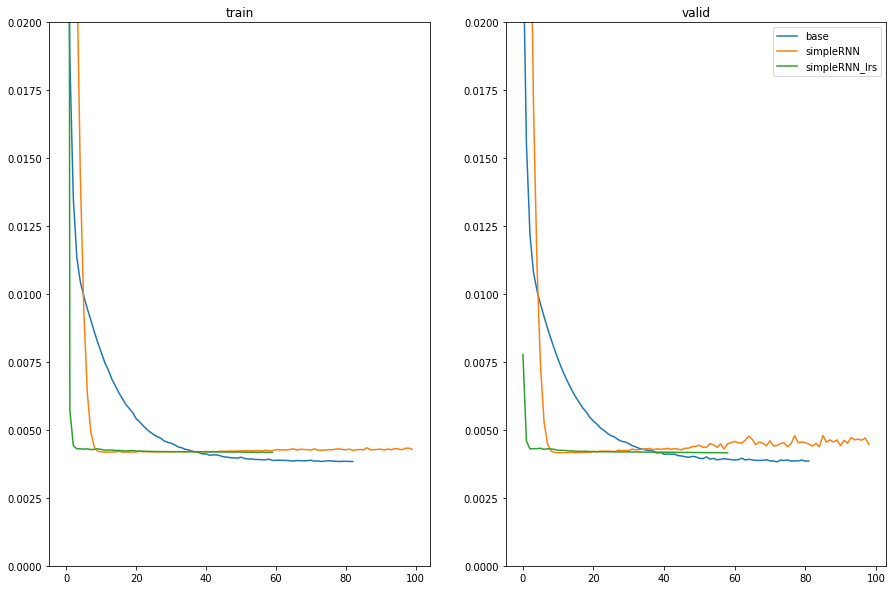

In [161]:
plot_results(result, ymax=0.02)

That fixed the wobbling at the end. But now we seem to hit a threshold; this time it is probably that our model is just too simple to fit the patterns.

Note how we still didn't improve on the linear model. So let's go deep.

In [179]:
%%time

def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 10
    # then it drops exponentially untill
    droptill = 40
    
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate


lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)


early_stop = EarlyStopping(patience=20, restore_best_weights=True)

model = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(32),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-2))
model.summary()


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_43 (SimpleRNN)    (None, None, 32)          1088      
_________________________________________________________________
simple_rnn_44 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________
CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms


Note the shapes. The first layer outputs a 3D-shape with `(batch, timesteps, channels)`. That is usefull, because we can feed that into a next `RNN` layer that requires 3D data!

We obtained this by added `return_sequences=True`.

For the last layer, we dropped that argument, and the ouput is flattened into `(batch, channels)`, which is what we need for our Dense layer.

In [180]:
%%time
result['deeprnn'] = model.fit(train_set,epochs=80, validation_data=valid_set, callbacks=[lrs], verbose=1)

Epoch 1/80
78/78 [==============================] - 2s 24ms/step - loss: 0.0191 - val_loss: 0.0102
Epoch 2/80
78/78 [==============================] - 2s 20ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 3/80
78/78 [==============================] - 2s 21ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 4/80
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 5/80
78/78 [==============================] - 2s 20ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 6/80
78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/80
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 8/80
78/78 [==============================] - 2s 22ms/step - loss: 0.0056 - val_loss: 0.0085
Epoch 9/80
78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - val_loss: 0.0086
Epoch 10/80
78/78 [==============================] - 2s 20ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 11/

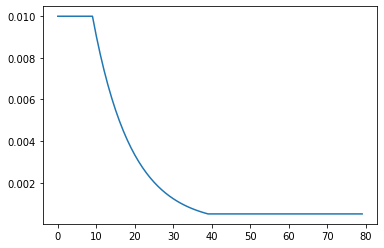

In [181]:
# we can check the learningrate drop
plt.plot(result['deeprnn'].history['lr'])

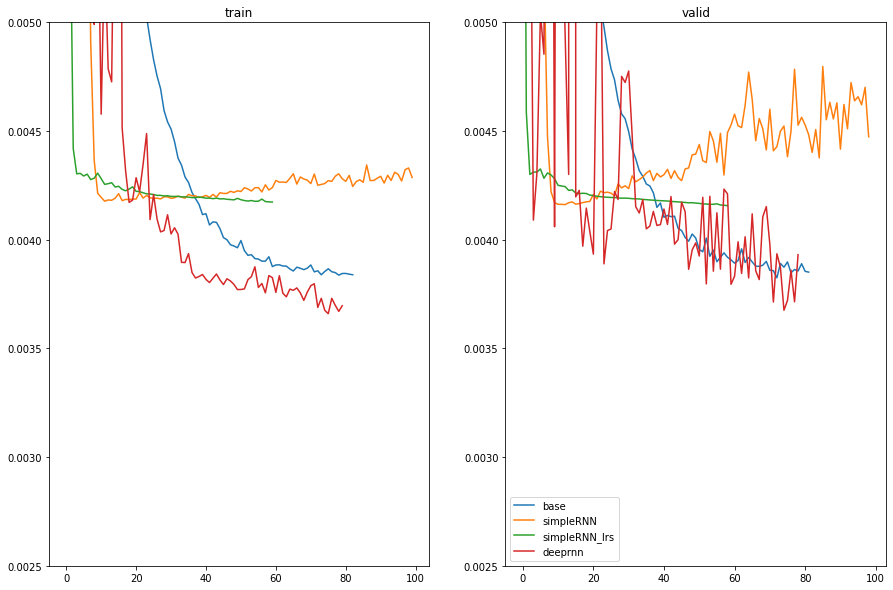

In [182]:
plot_results(result, ymin=0.0025, ymax=0.005)

So, that is better than our baseline!

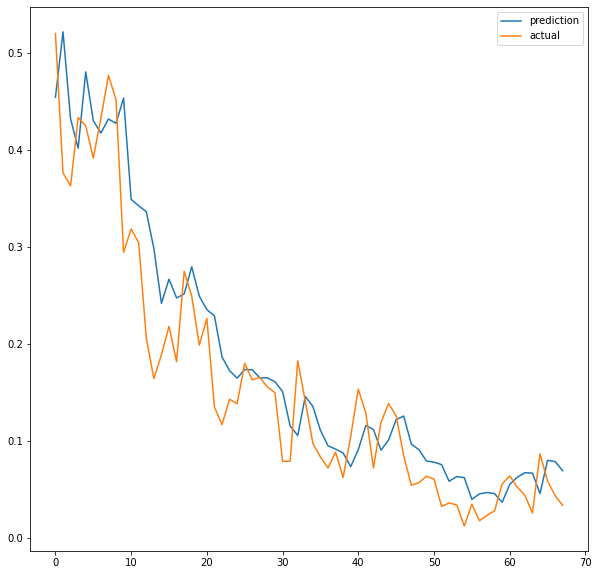

In [183]:
pred = generate_prediction(model, test[:100], window = 32, horizon = horizon)

We can also see, that it moved away from naive forecasting to actually trying to predict drops or rises before they actually happened.

## LSTM
Now, let's move on to LSTMs and see if that improves the model.

In [184]:
%%time
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=[None, 1]),
    LSTM(32),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam())
result['lstm'] = model.fit(train_set,epochs=60, validation_data=valid_set, verbose=1)

Epoch 1/60
78/78 [==============================] - 5s 62ms/step - loss: 0.0144 - val_loss: 0.0082
Epoch 2/60
78/78 [==============================] - 4s 49ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 3/60
78/78 [==============================] - 4s 48ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 4/60
78/78 [==============================] - 4s 49ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 5/60
78/78 [==============================] - 4s 47ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/60
78/78 [==============================] - 4s 47ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/60
78/78 [==============================] - 4s 47ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 8/60
78/78 [==============================] - 4s 47ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/60
78/78 [==============================] - 4s 48ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 10/60
78/78 [==============================] - 4s 48ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 11/

In [185]:
model.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
lstm_61 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


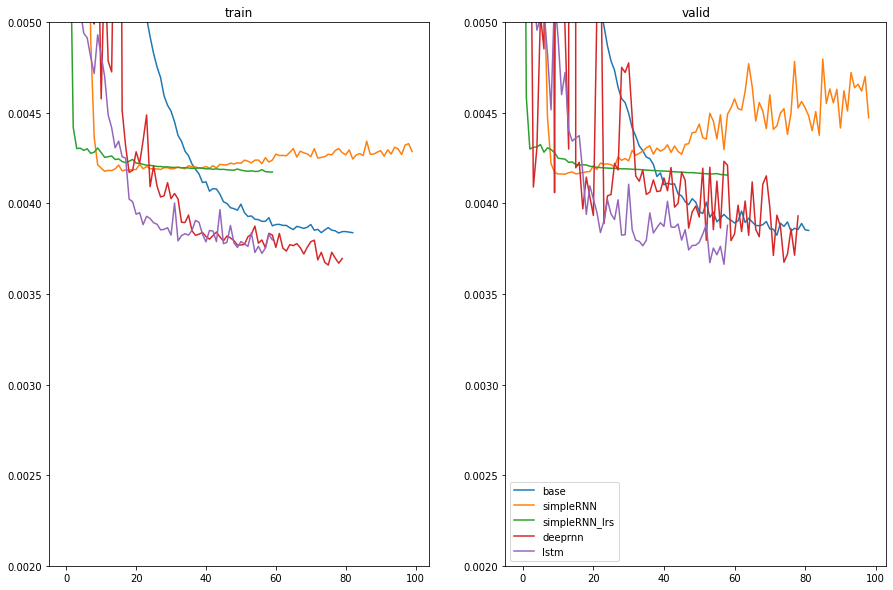

In [186]:
plot_results(result, ymin=0.002, ymax=0.005)

AH, again, improvement!

In [187]:
%%time
def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 10
    # then it drops untill
    droptill = 40
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    # after that, it drops by a factor 10, every 10 epochs.
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate


lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential([
    LSTM(32, return_sequences=True, input_shape=[None, 1]),
    LSTM(32),
    Dense(horizon)
])


early_stop = EarlyStopping(patience=15, restore_best_weights=True)

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
result['lstm_lrs'] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop, lrs], verbose=1)

Epoch 1/100
78/78 [==============================] - 5s 62ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 2/100
78/78 [==============================] - 4s 49ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 3/100
78/78 [==============================] - 4s 48ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 4/100
78/78 [==============================] - 4s 49ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/100
78/78 [==============================] - 4s 48ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/100
78/78 [==============================] - 4s 47ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/100
78/78 [==============================] - 4s 47ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 8/100
78/78 [==============================] - 4s 48ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/100
78/78 [==============================] - 4s 47ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 10/100
78/78 [==============================] - 4s 47ms/step - loss: 0.0045 - val_loss: 0.0042

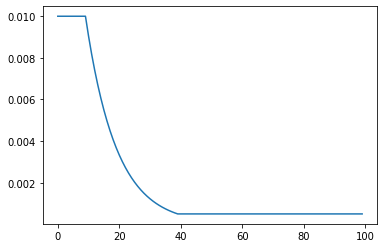

In [188]:
plt.plot(result['lstm_lrs'].history['lr'])

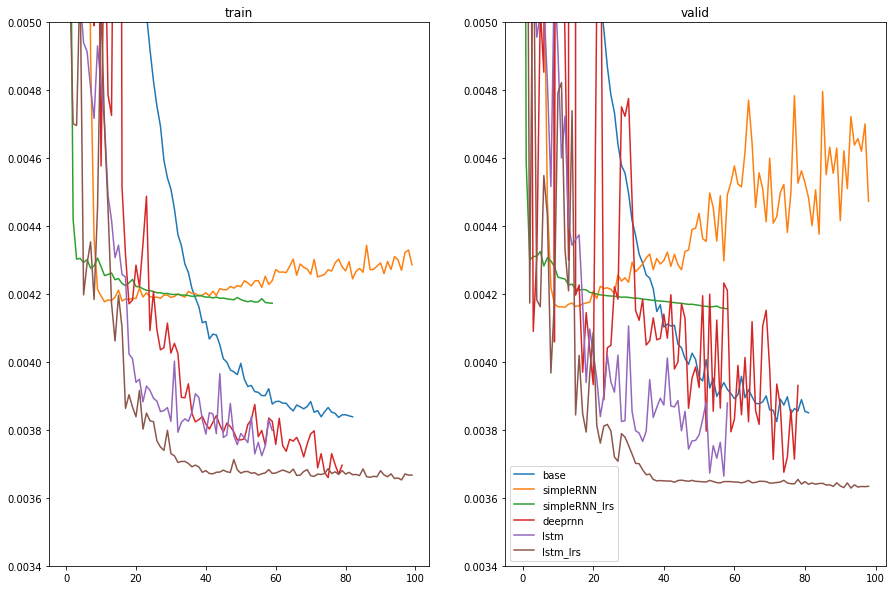

In [191]:
plot_results(result, ymin=0.0034, ymax=0.005)

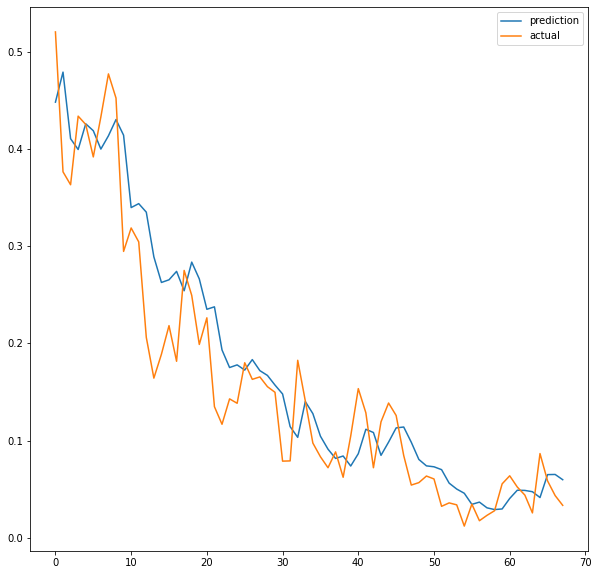

In [190]:
pred = generate_prediction(model, test[:100], window = 32, horizon = horizon)

# Hypertuning
By now, we have some intuitions about the models, learning rate, layers etc.
But what we didn't do, is changing the window size. We just picked an arbitrary size of 32, but maybe sunspots need more history! Let's find out.

In [192]:
%%time
def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 10
    # then it drops untill
    droptill = 40
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    # after that, it drops by a factor 10, every 10 epochs.
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate


lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

for window in range(16, 8*9+1, 8):

    window_size = window
    batch_size = 32
    shuffle_buffer = 25
    horizon = 1
    train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
    valid_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
    
    model = Sequential([
    LSTM(32, return_sequences=True, input_shape=[None, 1]),
    LSTM(32),
    Dense(horizon)
    ])
    
    
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
    name = 'lstm_lrs_' + str(window)
    print('starting: ', name)
    result[name] = model.fit(train_set,epochs=20, validation_data=valid_set, callbacks=[lrs], verbose=0)

starting:  lstm_lrs_16
starting:  lstm_lrs_24
starting:  lstm_lrs_32
starting:  lstm_lrs_40
starting:  lstm_lrs_48
starting:  lstm_lrs_56
starting:  lstm_lrs_64
starting:  lstm_lrs_72
CPU times: user 27min 40s, sys: 5min 28s, total: 33min 8s
Wall time: 14min 8s


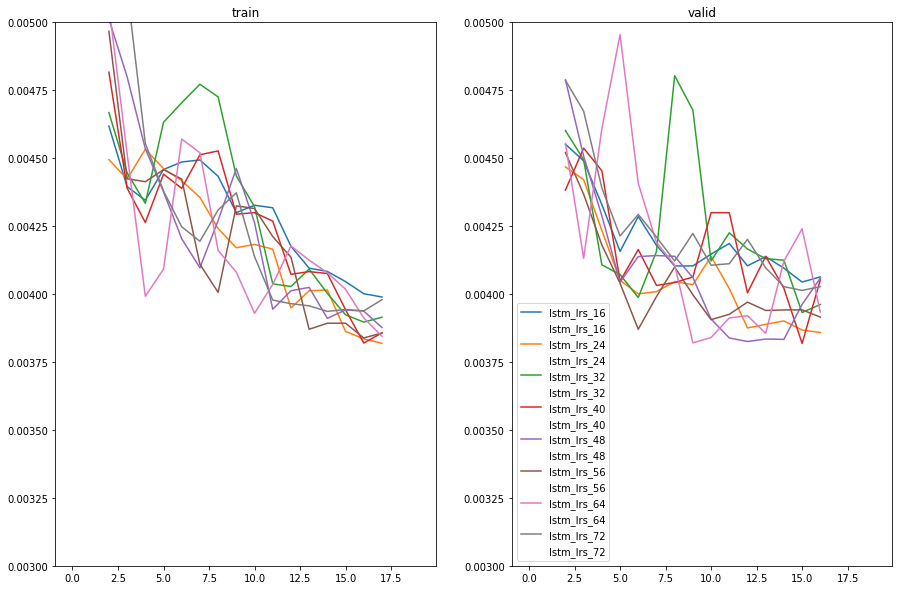

In [203]:
plot_results(result, ymin=0.003, ymax=0.005, subset='lrs_[0-9]', moving = 2, alpha=0)

So, higher windows seem to improve the model! 48, 56 and 64 are the top 3.

Let's test both an LSTM and GRU, with units ranging from 64 to 196. We will use between 0 and 3 additional layers, and output the desired horizon.

As you might have noticed by now, hypertuning is not a magic potion that works by throwing wide ranges of parameters at it. It is very easy to make your search space much to big to find something usefull!

How to check if your searchspace is to big? A good way to do so, is to calculate the size of what you are searching for. In the model below, we search for:

1. amount of units (10 options) 
2. celltype (2 options)
3. extra layers (4 options)

With this, we can calculate the total size of the search space: that would be 10 * 2 * 4, which equals 80.
If we set the `max_epochs` of the tuner to 5, we will sample 10 combinations. That means we are sampling 10 out of 80 options. While that is just 12.5%, it is enough to get a reasonable result.

Let's say you might still wonder what the best learning rate is, or even the best optimizer.
So, we could add:

4. optimizer (adam, sgd, rmsprop) (3 options)
5. learning rate (1e-2, 1e-3, 1e-4) (3 options)

While this might seems like just a small addition, our search space has suddenly become much bigger! We will now search 10 * 2 * 4 * 3 * 3 = 720 options! Sampling just 10 of them, will give us just 1.4% of the searchspace!

The chance that you will end up with a solution that is even *worse* than what we did by hand, is huge! One way to encounter this would be to increase the amount of models to test. But this would take hours, if we want to get to the same 12.5% coverage. So, to get the best results with hypertuning, keep your searchspace limited (unless you have vast resources to search the space!).

In [208]:
window_size = 64
batch_size = 32
shuffle_buffer = 25
horizon = 1
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [216]:
def build_model(hp):
    input = Input(shape = [None, 1])

    units = hp.Int('units', 32, 196, 16)
    celltype = hp.Choice('Type', ['LSTM', 'GRU'])

    # first layer
    if celltype == "LSTM":
        x = LSTM(units, return_sequences=True)(input)
    if celltype == "GRU":
        x = GRU(units, return_sequences=True)(input)

    # inner layers, if any
    for i in range(hp.Int('layers', 0, 3)):
        name = 'layer_{0}'.format(i)
        if celltype == "LSTM":
            x = LSTM(units, return_sequences=True)(x)
        if celltype == "GRU":
            x = GRU(units, return_sequences=True)(x)
    
    # last layer
    if celltype == "LSTM":
        x = LSTM(units)(x)
    if celltype == "GRU":
        x = GRU(units)(x)

    output = Dense(horizon)(x)
    
    optimizer = Adam(lr=1e-2)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [217]:
%%time
import kerastuner as kt
# cleaning up folders from old runs
!rm -rf ktuner 
!rm -rf logs/hp

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    factor=3,
    directory='ktuner',
    project_name='ts'
)
tuner.search(train_set, epochs = 5, validation_data = valid_set)

Trial 10 Complete [00h 01m 16s]
val_loss: 0.004329870244693041

Best val_loss So Far: 0.0040081507826074106
Total elapsed time: 00h 14m 02s
INFO:tensorflow:Oracle triggered exit
CPU times: user 41min 59s, sys: 6min 7s, total: 48min 6s
Wall time: 14min 5s


In [229]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'units': 109,
 'Type': 'GRU',
 'layers': 3,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '9717ede6400542f85554a56c65108d8c'}

In [230]:
model = tuner.get_best_models()[0]
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, None, 109)         36624     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 109)         71940     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 109)         71940     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 109)         71940     
_________________________________________________________________
gru_4 (GRU)                  (None, 109)               71940     
_________________________________________________________________
dense (Dense)                (None, 1)                

In [231]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 10
    # then it drops untill
    droptill = 40
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    # after that, it drops by a factor 10, every 10 epochs.
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [232]:
%%time
# will take 40 minutes to run
checkpointer = ModelCheckpoint(filepath = 'checkpoint/hyper',
                               verbose=0,
                               save_best_only=True)
result['hyper'] = model.fit(train_set, epochs=50, validation_data=valid_set, callbacks=[lrs, checkpointer], verbose = 1)

Epoch 1/60
77/77 [==============================] - 41s 539ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 2/60
77/77 [==============================] - 40s 519ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 3/60
77/77 [==============================] - 43s 559ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 4/60
77/77 [==============================] - 40s 523ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 5/60
77/77 [==============================] - 38s 496ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 6/60
77/77 [==============================] - 38s 496ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 7/60
77/77 [==============================] - 38s 499ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 8/60
77/77 [==============================] - 43s 561ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/60
77/77 [==============================] - 41s 526ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/60
77/77 [==============================] - 39s 511ms/step - loss: 0.0047 - val_lo

In [233]:
model.evaluate(valid_set)

77/77 [==============================] - 12s 154ms/step - loss: 0.0033


0.0033441340477757876

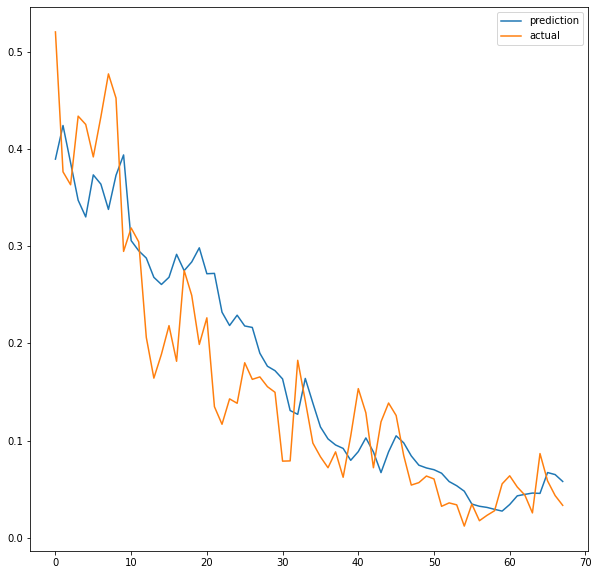

In [234]:
pred = generate_prediction(model, test[:100,:], seq_size, horizon)

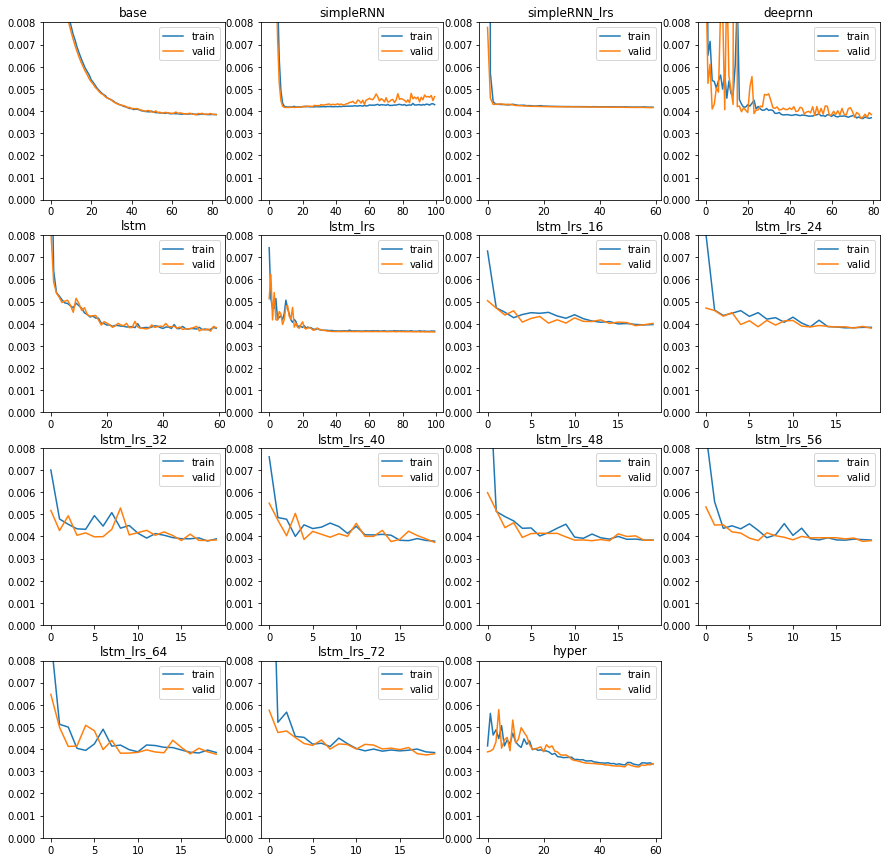

In [235]:
plot_results(result, ymin = 0.003, ymax=0.008, grid=True)

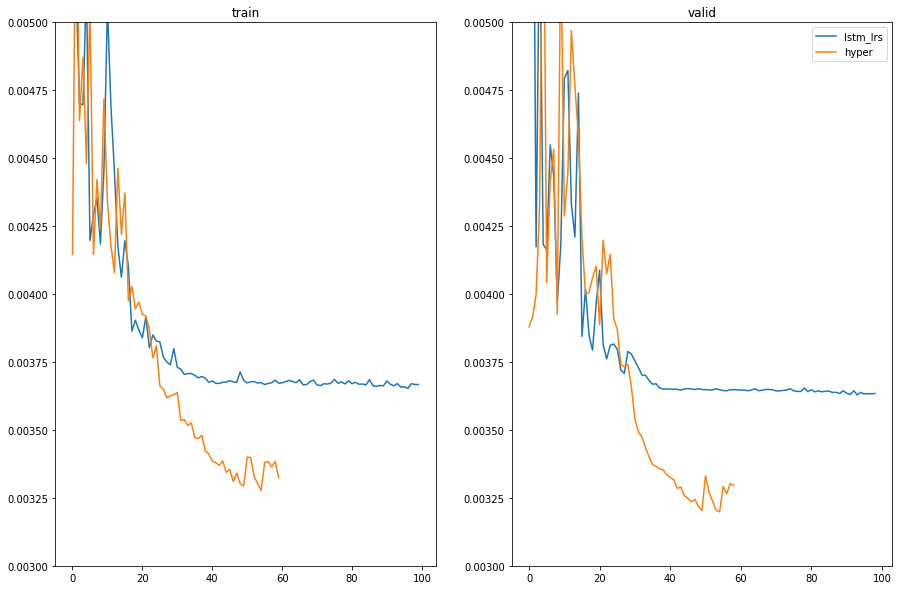

In [239]:
plot_results(result, ymin = 0.003, ymax=0.005, subset="lstm_lrs$|hyper")